In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
file_path = "/content/cracked.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Define month names
month_names = [
    "Jan 2017", "Feb 2017", "Mar 2017", "Apr 2017", "May 2017", "Jun 2017",
    "Jul 2017", "Aug 2017", "Sep 2017", "Oct 2017", "Nov 2017", "Dec 2017",
    "Jan 2018", "Feb 2018", "Mar 2018", "Apr 2018", "May 2018", "Jun 2018",
    "Jul 2018", "Aug 2018", "Sep 2018", "Oct 2018", "Nov 2018", "Dec 2018",
    "Jan 2019", "Feb 2019", "Mar 2019", "Apr 2019", "May 2019", "Jun 2019",
    "Jul 2019", "Aug 2019", "Sep 2019", "Oct 2019", "Nov 2019", "Dec 2019",
    "Jan 2020", "Feb 2020", "Mar 2020", "Apr 2020", "May 2020", "Jun 2020",
    "Jul 2020", "Aug 2020", "Sep 2020", "Oct 2020", "Nov 2020", "Dec 2020",
    "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021", "May 2021", "Jun 2021",
    "Jul 2021", "Aug 2021", "Sep 2021", "Oct 2021", "Nov 2021", "Dec 2021",
    "Jan 2022", "Feb 2022", "Mar 2022", "Apr 2022", "May 2022", "Jun 2022",
    "Jul 2022", "Aug 2022", "Sep 2022", "Oct 2022", "Nov 2022", "Dec 2022",
    "Jan 2023", "Feb 2023", "Mar 2023", "Apr 2023", "May 2023", "Jun 2023",
    "Jul 2023", "Aug 2023", "Sep 2023", "Oct 2023"
]

# Create labels
type_labels = {
    1: "Empty plot of land",
    2: "Flat",
    3: "Bungalow",
    4: "Chalet",
    5: "Terraced house",
    6: "End-terraced house",
    7: "Semi-detached house",
    8: "Detached house"
}

pcode_labels = {
    1: "South and East Central Norwich",
    2: "West Central Norwich",
    3: "North Central Norwich",
    4: "South-West Norwich",
    5: "West Norwich",
    6: "North Norwich",
    7: "East Norwich",
    8: "North-West Norwich"
}

# Apply labels
df['type_label'] = df['type'].map(type_labels).fillna("Unknown")
df['pcode_label'] = df['pcode'].map(pcode_labels).fillna("Unknown")
df['month_label'] = df['month'].apply(lambda x: month_names[x-1] if 1 <= x <= len(month_names) else "Unknown")

# Add energy efficiency labels
df['dg_label'] = df['dg'].apply(lambda x: 'double glazing' if x == 1 else 'not double glazing')
df['solar_label'] = df['solar'].apply(lambda x: 'solar panels' if x == 1 else 'no solar panels')
df['loft_label'] = df['loft'].apply(lambda x: 'loft insulation' if x == 1 else 'no loft insulation')

# Split month_label into Months_L and Years_L
df[['Months_L', 'Years_L']] = df['month_label'].str.split(" ", expand=True)

# Optionally convert to category type (for ML or summary stats)
categorical_columns = ['type_label', 'pcode_label', 'month_label', 'dg_label', 'solar_label', 'loft_label', 'Months_L', 'Years_L']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Drop the 'house' column if it exists
if 'house' in df.columns:
    df.drop(columns='house', inplace=True)

# View the cleaned dataframe
df.head()

,price,beds,baths,recs,garages,type,pcode,sqm,dg,solar,...,age,month,type_label,pcode_label,month_label,dg_label,solar_label,loft_label,Months_L,Years_L
0,694.737976,5,2,3,2,8,4,226.199997,1,0,...,69,1,Detached house,South-West Norwich,Jan 2017,double glazing,no solar panels,loft insulation,Jan,2017
1,96.709999,2,1,2,0,5,1,67.400002,0,0,...,95,1,Terraced house,South and East Central Norwich,Jan 2017,not double glazing,no solar panels,loft insulation,Jan,2017
2,377.989014,3,1,2,0,8,2,121.300003,0,1,...,73,1,Detached house,West Central Norwich,Jan 2017,not double glazing,solar panels,loft insulation,Jan,2017
3,129.748001,2,1,1,0,5,5,56.799999,1,0,...,60,1,Terraced house,West Norwich,Jan 2017,double glazing,no solar panels,loft insulation,Jan,2017
4,140.313004,2,1,1,1,5,6,58.500000,0,0,...,19,1,Terraced house,North Norwich,Jan 2017,not double glazing,no solar panels,loft insulation,Jan,2017


In [ ]:
df.columns

Index(['price', 'beds', 'baths', 'recs', 'garages', 'type', 'pcode', 'sqm',
       'dg', 'solar', 'loft', 'gsize', 'poll', 'noise', 'age', 'month',
       'type_label', 'pcode_label', 'month_label', 'dg_label', 'solar_label',
       'loft_label', 'Months_L', 'Years_L'],
      dtype='object')

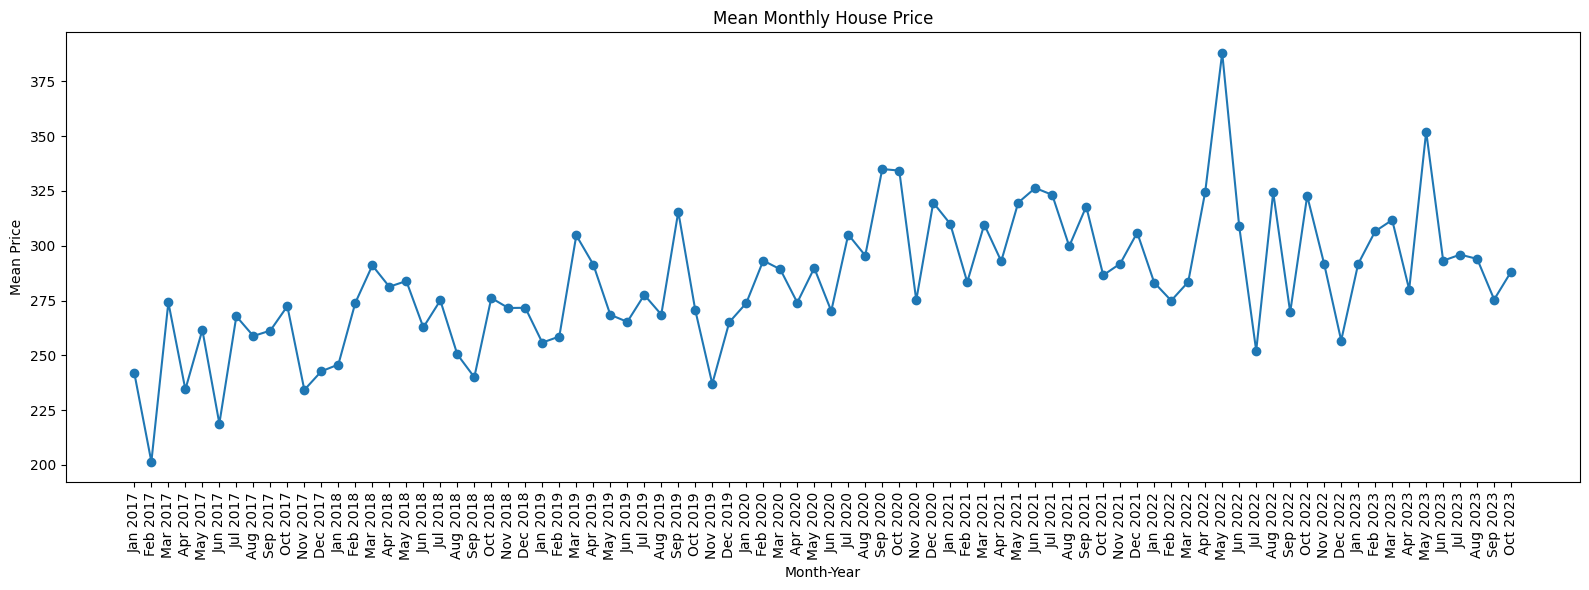

In [ ]:
# Split month_label into Month and Year columns
df[['Month', 'Year']] = df['month_label'].str.split(" ", expand=True)
# Convert Year to integer for sorting
df['Year'] = df['Year'].astype(int)
# Group by Year and Month, then calculate mean price
mean_price = df.groupby(['Year', 'Month'])['price'].mean().reset_index()
# To preserve correct month order for plotting/sorting
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mean_price['Month'] = pd.Categorical(mean_price['Month'], categories=month_order, ordered=True)
# Sort the dataframe by Year then Month
mean_price = mean_price.sort_values(['Year', 'Month'])

# Create a combined label for plotting
mean_price['Month_Year'] = mean_price['Month'].astype(str) + " " + mean_price['Year'].astype(str)

plt.figure(figsize=(16, 6))
plt.plot(mean_price['Month_Year'], mean_price['price'], marker='o', linestyle='-')
plt.title('Mean Monthly House Price')
plt.xlabel('Month-Year')
plt.ylabel('Mean Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<ipython-input-5-d2a251ef484e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= df, x='Month', y='price', palette='Set2')


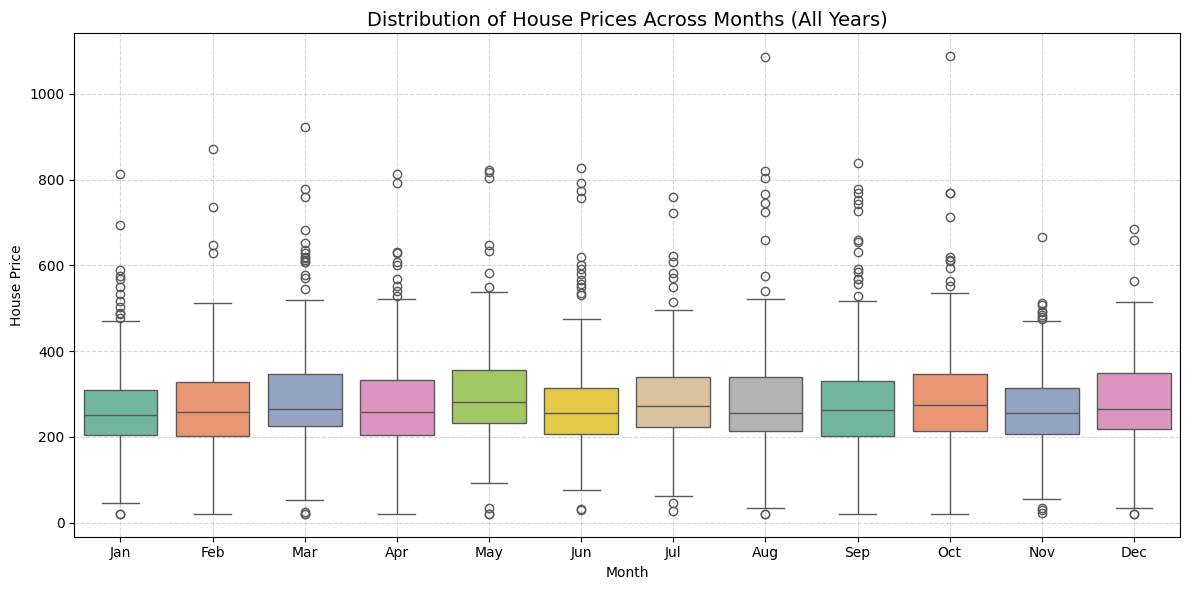

In [ ]:
# Split into Month and Year
df[['Month', 'Year']] = df['month_label'].str.split(" ", expand=True)
# Optional: Ensure Month is categorical and ordered correctly
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

#Plot Distribution of Price by Month
plt.figure(figsize=(12, 6))
sns.boxplot(data= df, x='Month', y='price', palette='Set2')
plt.title('Distribution of House Prices Across Months (All Years)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('House Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

solar_label
No Solar Panels    1757
Solar Panels        578
Name: count, dtype: int64


<ipython-input-6-3e852e1f574d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= df, x='solar_label', y='price', palette='Set2')


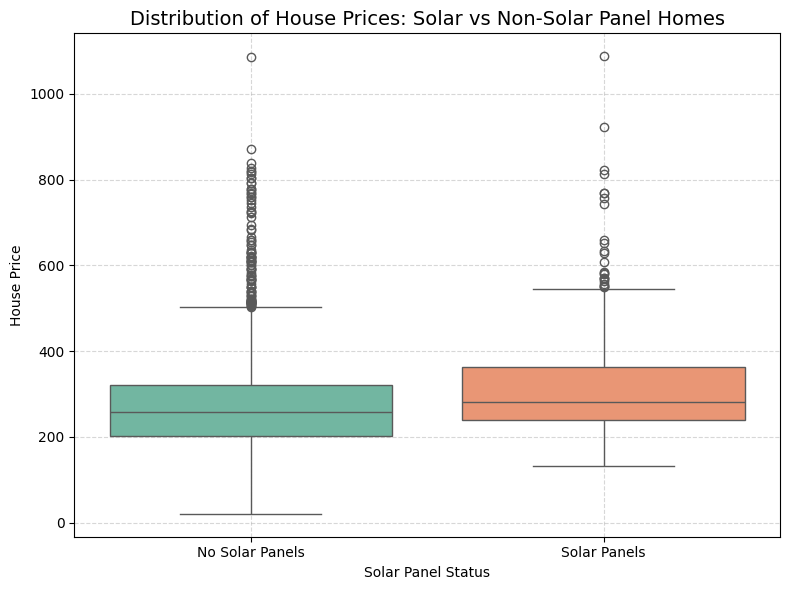

In [ ]:
df['solar_label'] = df['solar'].map({1: 'Solar Panels', 0: 'No Solar Panels'})
# Check the unique values
print(df['solar_label'].value_counts())
# Plotting Violin Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data= df, x='solar_label', y='price', palette='Set2')
# Beautify the plot
plt.title('Distribution of House Prices: Solar vs Non-Solar Panel Homes', fontsize=14)
plt.xlabel('Solar Panel Status')
plt.ylabel('House Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<ipython-input-7-0bfac5ce3292>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data= df, x='pcode_label', y='price', palette='Spectral')


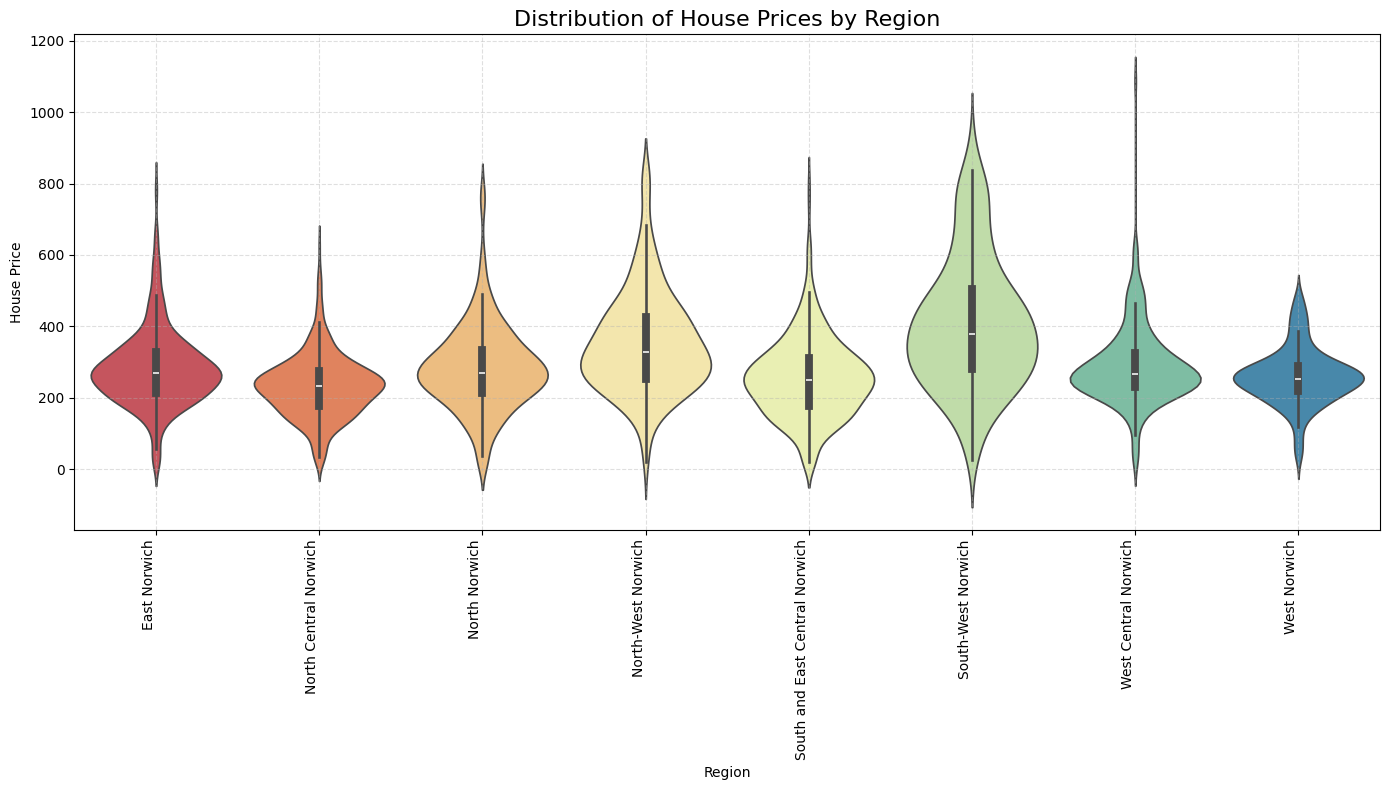

In [ ]:
# Plotting Violin Plot by Region
plt.figure(figsize=(14, 8))
sns.violinplot(data= df, x='pcode_label', y='price', palette='Spectral')
# Beautify the plot
plt.title('Distribution of House Prices by Region', fontsize=16)
plt.xlabel('Region')
plt.ylabel('House Price')
plt.xticks(rotation=90, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

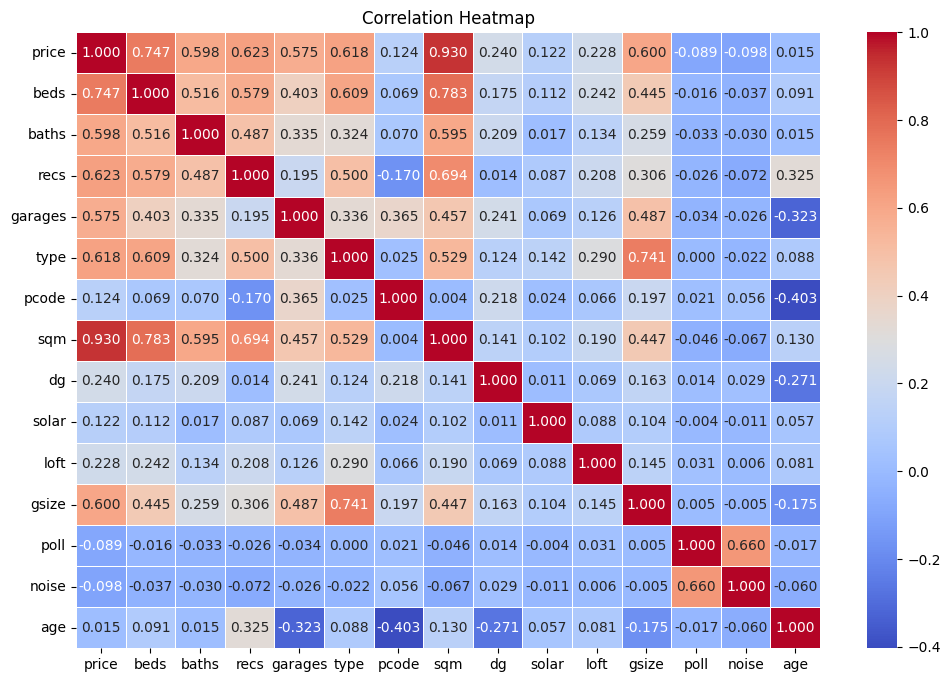

In [ ]:
features = ['price', 'beds', 'baths', 'recs', 'garages', 'type', 'pcode', 'sqm',
       'dg', 'solar', 'loft', 'gsize', 'poll', 'noise', 'age']
correlation_matrix = df[features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [38]:
df[features].describe()

,price,beds,baths,recs,garages,type,pcode,sqm,dg,solar,loft,gsize,poll,noise,age
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,284.282218,2.757173,1.105353,1.618415,0.518630,5.026124,4.088651,90.187751,0.287366,0.247537,0.578158,169.709251,26.137045,80.230407,53.536617
std,126.391905,0.960068,0.418142,0.699800,0.604517,1.997364,2.295319,38.360542,0.452631,0.431674,0.493959,160.096085,10.422772,34.991014,42.272480
min,20.500000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,20.000000,0.000000
25%,211.665001,2.000000,1.000000,1.000000,0.000000,3.000000,2.000000,71.599998,0.000000,0.000000,0.000000,84.299999,19.000000,49.000000,20.000000
50%,263.243988,3.000000,1.000000,2.000000,0.000000,5.000000,3.000000,83.199997,0.000000,0.000000,1.000000,113.550003,26.000000,80.000000,41.000000
75%,331.887512,3.000000,1.000000,2.000000,1.000000,7.000000,6.000000,102.599998,1.000000,0.000000,1.000000,220.250000,34.000000,112.000000,94.000000
max,1087.787964,7.000000,4.000000,5.000000,2.000000,8.000000,8.000000,372.000000,1.000000,1.000000,1.000000,1011.549988,61.000000,140.000000,426.000000


In [ ]:
x = ['beds', 'baths', 'recs', 'garages', 'type', 'pcode', 'sqm',
       'dg', 'solar', 'loft', 'gsize', 'poll', 'noise', 'age']
# Separate features (X) and target (y)
X = df[x]
y = df['price']
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1868, 14), (467, 14), (1868,), (467,))

**TRAINING THE ANN MODEL USING DIFERRENT LEARNING RATE ON A BATCH SIZE = 64**


Training model with learning rate: 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


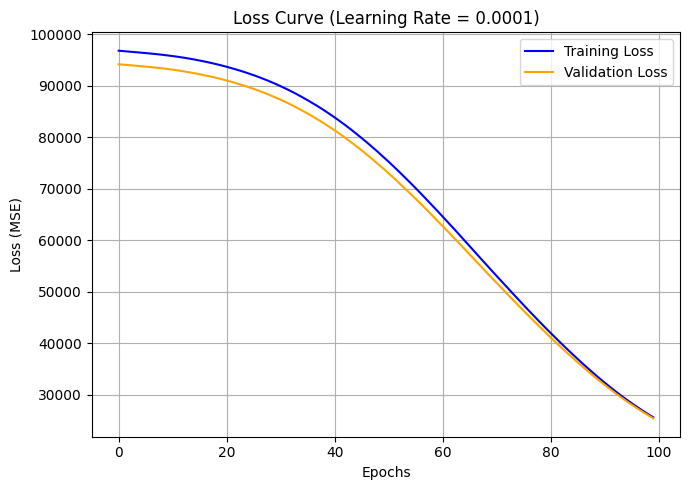

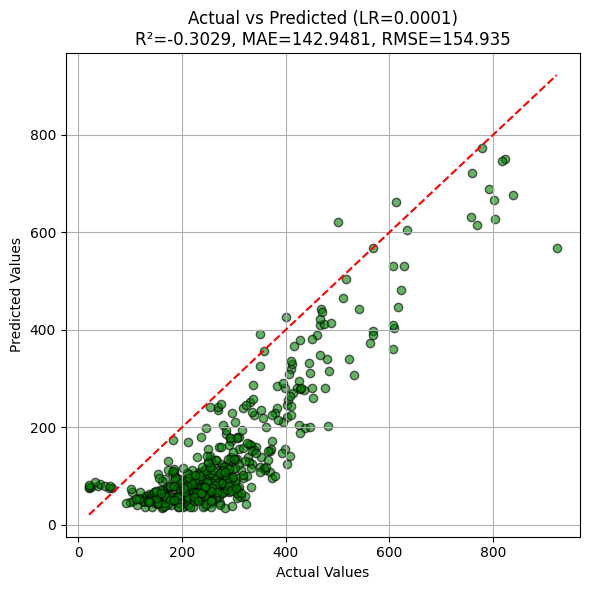


Training model with learning rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


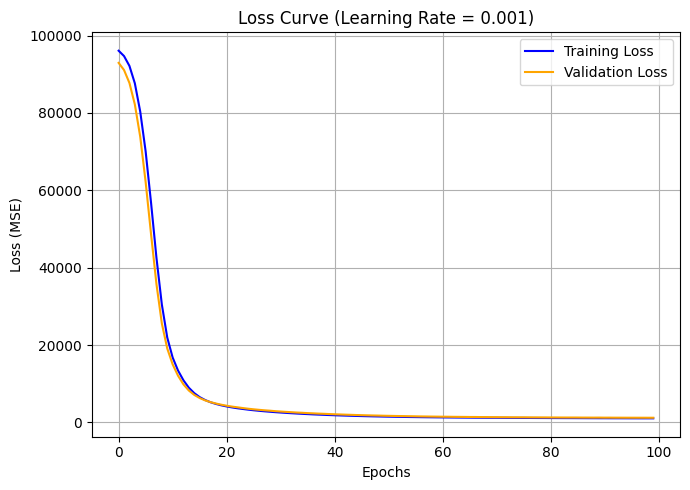

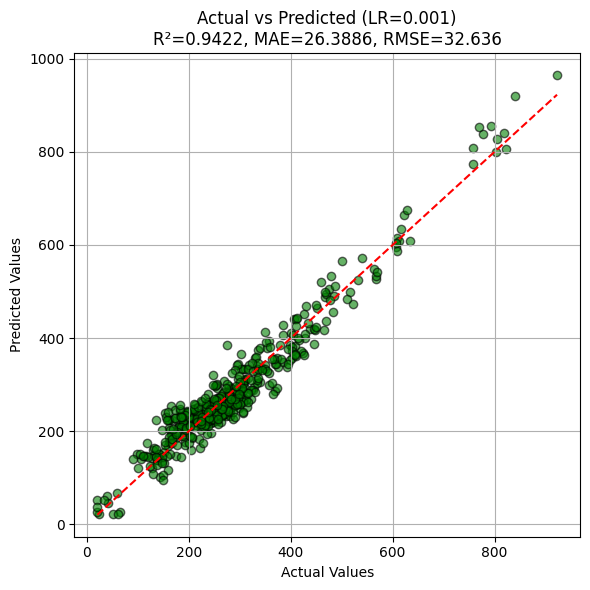


Training model with learning rate: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


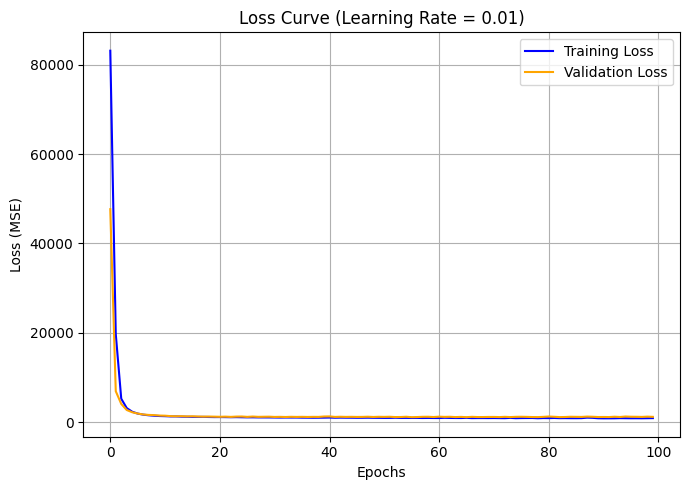

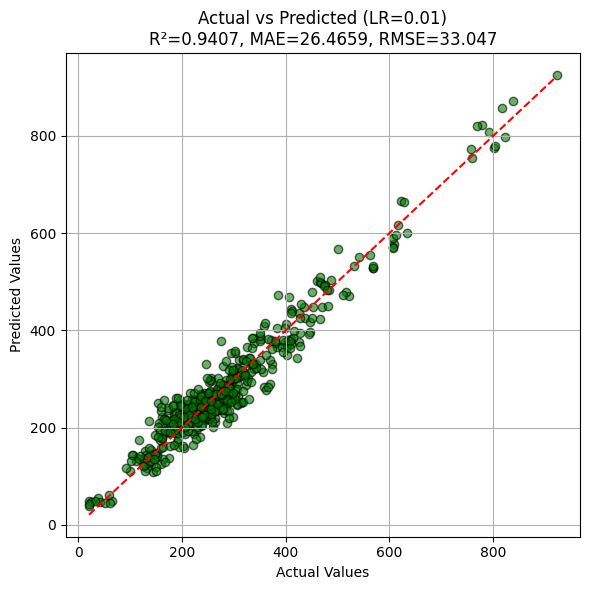


Training model with learning rate: 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


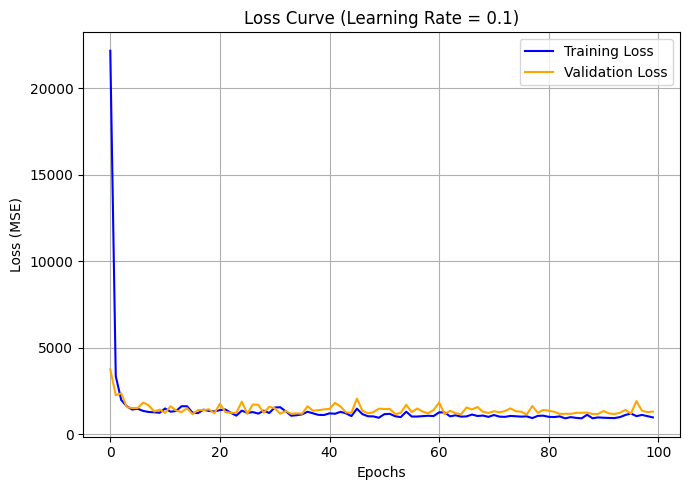

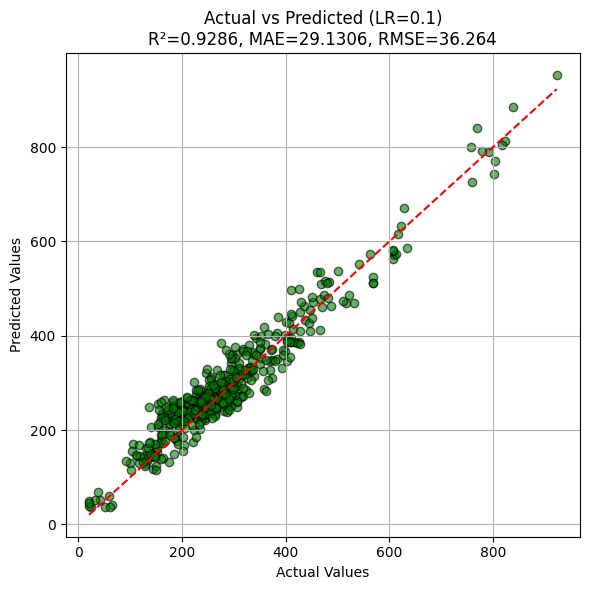

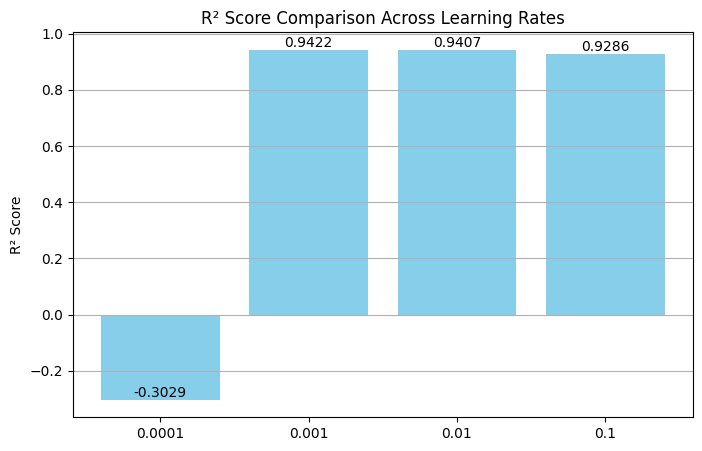

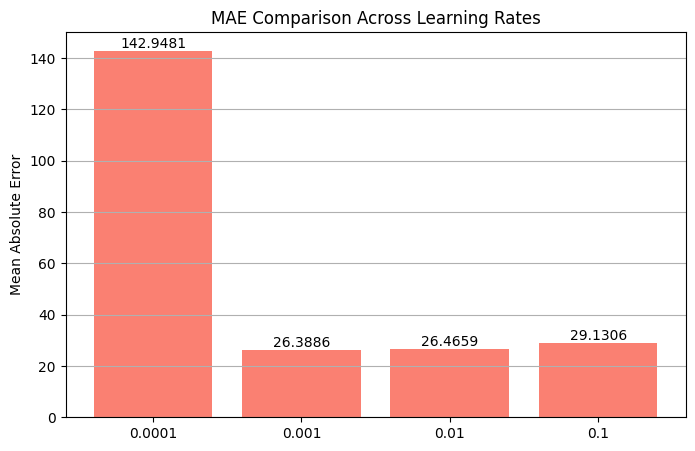

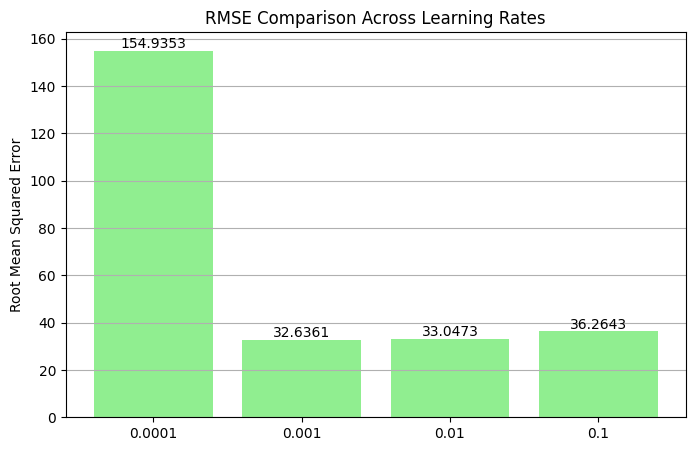

In [36]:
# Define learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# Store results
results = {}

for lr in learning_rates:
    print(f"\nTraining model with learning rate: {lr}")

    # Build the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Regression output

    # Compile with custom learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=0)

    # Predict
    y_pred = model.predict(X_test).flatten()

    # Evaluate
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Save results
    results[lr] = {
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'y_pred': y_pred,
        'history': history
    }

    # -------------------- Plot Loss Curve --------------------
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Loss Curve (Learning Rate = {lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------------------- Plot Actual vs Predicted --------------------
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='green', edgecolor='k')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted (LR={lr})\nR²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.3f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------- Summary Comparison Bar Plots --------------------

# Collect values
lr_labels = [str(lr) for lr in learning_rates]
r2_vals = [results[lr]['r2'] for lr in learning_rates]
mae_vals = [results[lr]['mae'] for lr in learning_rates]
rmse_vals = [results[lr]['rmse'] for lr in learning_rates]

# R² Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(lr_labels, r2_vals, color='skyblue')
plt.title("R² Score Comparison Across Learning Rates")
plt.ylabel("R² Score")
plt.grid(axis='y')
for bar, val in zip(bars, r2_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.4f}", ha='center', va='bottom')
plt.show()

# MAE Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(lr_labels, mae_vals, color='salmon')
plt.title("MAE Comparison Across Learning Rates")
plt.ylabel("Mean Absolute Error")
plt.grid(axis='y')
for bar, val in zip(bars, mae_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.4f}", ha='center', va='bottom')
plt.show()

# RMSE Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(lr_labels, rmse_vals, color='lightgreen')
plt.title("RMSE Comparison Across Learning Rates")
plt.ylabel("Root Mean Squared Error")
plt.grid(axis='y')
for bar, val in zip(bars, rmse_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.4f}", ha='center', va='bottom')
plt.show()

**TRAINING THE ANN MODEL USING DIFERRENT BATCH SIZES**


Training model with batch size: 64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


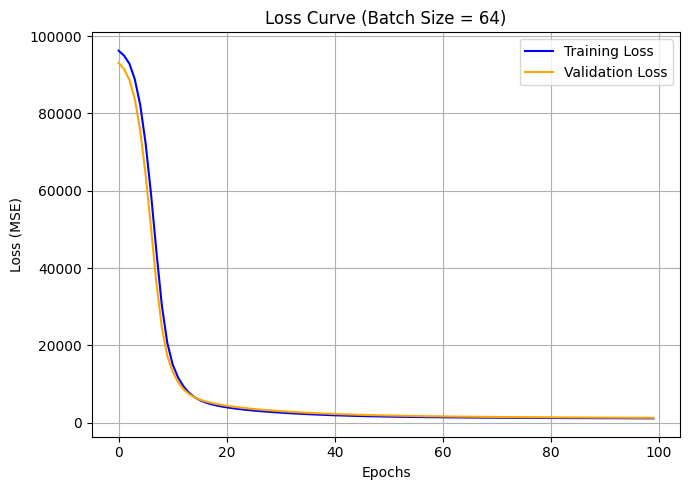

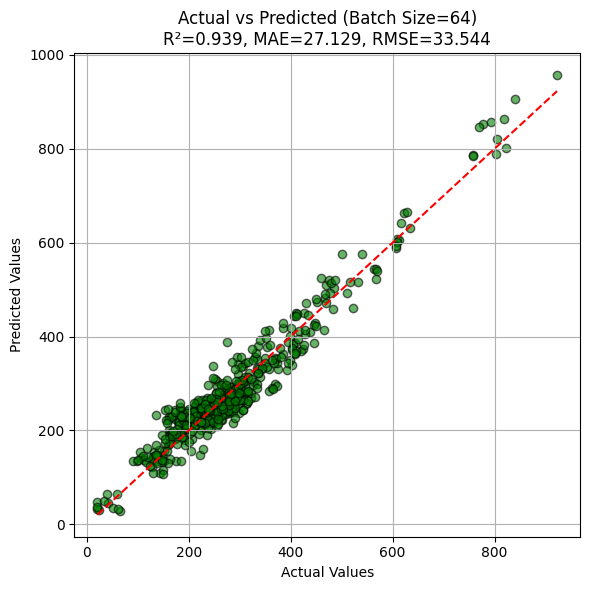


Training model with batch size: 128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


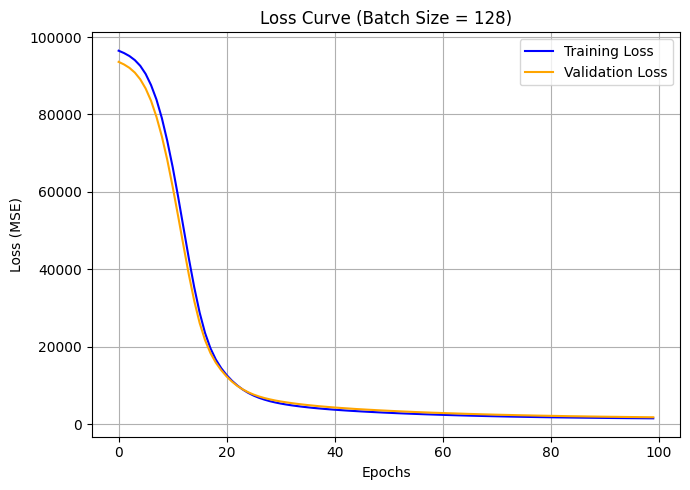

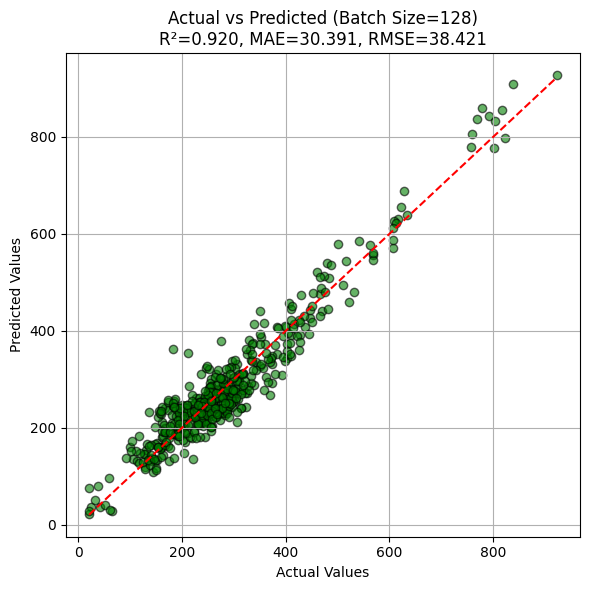


Training model with batch size: 256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


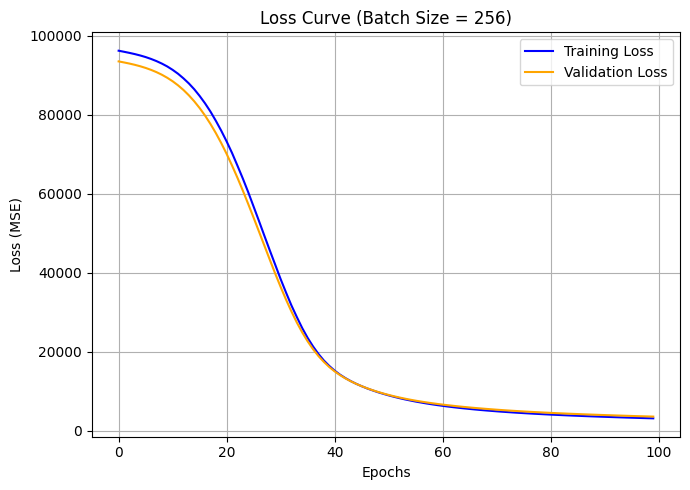

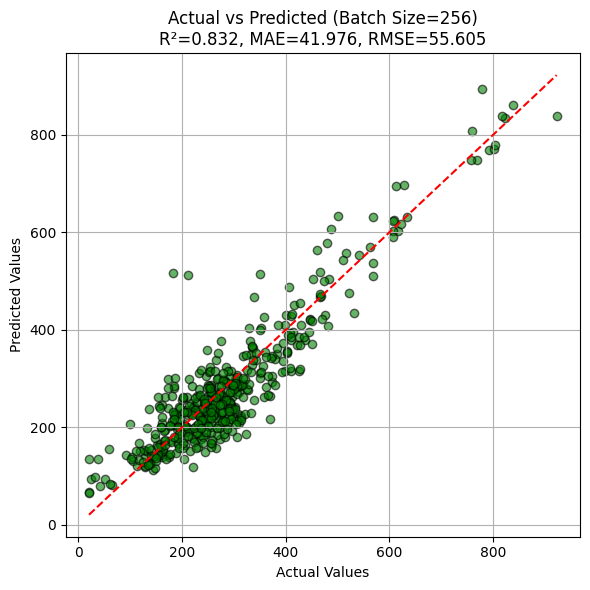

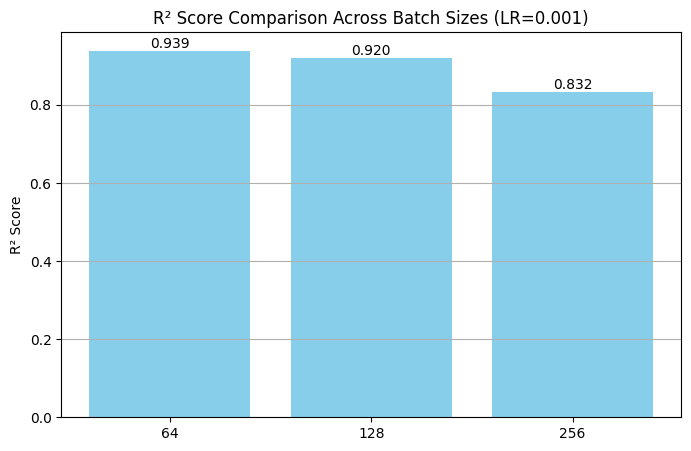

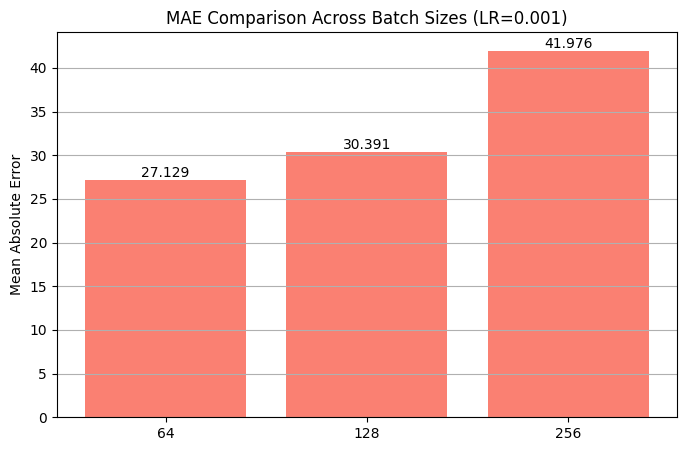

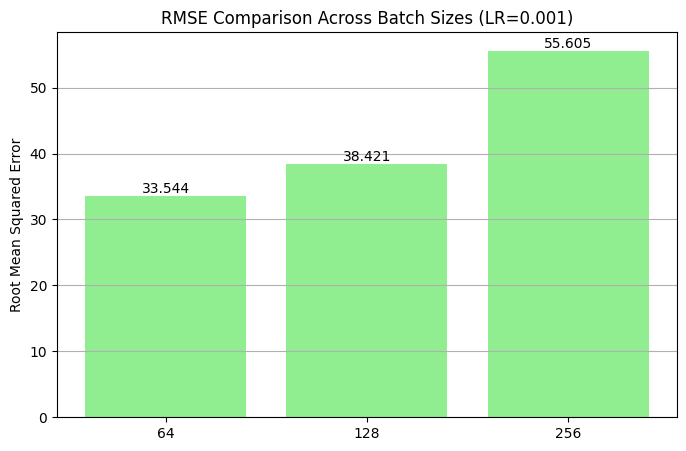

In [37]:
# Define batch sizes and fixed learning rate
batch_sizes = [64, 128, 256]
learning_rate = 0.001

# Store results
results = {}

for bs in batch_sizes:
    print(f"\nTraining model with batch size: {bs}")

    # Build the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile with fixed learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=bs, verbose=0)

    # Predict on test set
    y_pred = model.predict(X_test).flatten()

    # Evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store results
    results[bs] = {
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'y_pred': y_pred,
        'history': history
    }

    # -------------------- Plot Loss Curve --------------------
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Loss Curve (Batch Size = {bs})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------------------- Plot Actual vs Predicted --------------------
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='green', edgecolor='k')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted (Batch Size={bs})\nR²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------- Summary Comparison Bar Plots --------------------

# Collect values
bs_labels = [str(bs) for bs in batch_sizes]
r2_vals = [results[bs]['r2'] for bs in batch_sizes]
mae_vals = [results[bs]['mae'] for bs in batch_sizes]
rmse_vals = [results[bs]['rmse'] for bs in batch_sizes]

# R² Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(bs_labels, r2_vals, color='skyblue')
plt.title("R² Score Comparison Across Batch Sizes (LR=0.001)")
plt.ylabel("R² Score")
plt.grid(axis='y')
for bar, val in zip(bars, r2_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.3f}", ha='center', va='bottom')
plt.show()

# MAE Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(bs_labels, mae_vals, color='salmon')
plt.title("MAE Comparison Across Batch Sizes (LR=0.001)")
plt.ylabel("Mean Absolute Error")
plt.grid(axis='y')
for bar, val in zip(bars, mae_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.3f}", ha='center', va='bottom')
plt.show()

# RMSE Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(bs_labels, rmse_vals, color='lightgreen')
plt.title("RMSE Comparison Across Batch Sizes (LR=0.001)")
plt.ylabel("Root Mean Squared Error")
plt.grid(axis='y')
for bar, val in zip(bars, rmse_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.3f}", ha='center', va='bottom')
plt.show()